In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import os
import glob

In [58]:
def train(criterion, optimizer, model, num_epochs, device):
    loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        loss_per_epoch = 0
        for images, label in trainloader:
            optimizer.zero_grad()

            images, label = images.to(device), label.to(device)

            outputs = model(images)

            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            loss_per_epoch += loss

        correct = 0
        total = 0

        with torch.no_grad():
            for images, label in testloader:
                images, label = images.to(DEVICE), label.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        print(f"epoch: {epoch}, loss_per_epoch: {loss_per_epoch}, test_accuracy: {correct/total}")
        loss_history.append(loss_per_epoch.cpu().detach().numpy())
        test_acc_history.append((correct * 100/total))

    return loss_history, test_acc_history

In [59]:
DEVICE = torch.device("cuda")

In [60]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


## Linear

In [61]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear (32 * 32 * 3, 1000),          # 3072 -> 1000          /3
            nn.ReLU(inplace=True),
            nn.Linear (1000, 100),                  # 1000 -> 100       /10
            nn.ReLU(inplace=True),
            nn.Linear (100, 10),                    # 100 -> 10         /10
        )
    def forward(self, x):
        x = x.view(256, 32 * 32 * 3)
        x = self.classifier(x)

        return x

In [62]:
'''model_1 = Linear()
model_1 = model_1.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0005)

num_epochs = 10'''

'model_1 = Linear()\nmodel_1 = model_1.to(DEVICE)\n\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model_1.parameters(), lr=0.0005)\n\nnum_epochs = 10'

In [63]:
'''print("model_1 (linear) network training")
loss_history, test_acc_history = train(criterion, optimizer, model_1, num_epochs = num_epochs, device = DEVICE)'''

'print("model_1 (linear) network training")\nloss_history, test_acc_history = train(criterion, optimizer, model_1, num_epochs = num_epochs, device = DEVICE)'

In [64]:
'''plt.plot(list(range(num_epochs)), loss_history)
plt.plot(list(range(num_epochs)), test_acc_history)
plt.title("Traning Loss History")
plt.show()'''

'plt.plot(list(range(num_epochs)), loss_history)\nplt.plot(list(range(num_epochs)), test_acc_history)\nplt.title("Traning Loss History")\nplt.show()'

# Conv

In [65]:
class Conv_1(nn.Module):
    def __init__(self):
        super(Conv_1, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size = 5, stride = 1),              # (3 ,32, 32) -> (96, 28, 28)
            nn.ReLU(inplace=True),

                                              # (96, 14, 14)

            nn.Conv2d(96, 128, kernel_size = 3),                        # (96, 14, 14) -> (128, 12, 12)
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 192, kernel_size = 3),                        # (128, 12, 12) -> (192, 10, 10)
            nn.ReLU(inplace=True),
                                                         # (192, 10, 10) -> (192, 5, 5)
            
            nn.Conv2d(192, 256, kernel_size = 3, padding = 1),              # (192, 5, 5) -> (256, 5, 5) 5-3 + 2*1 + 1 
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),             # (256, 5, 5) -> (512, 5, 5)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
            
            
            # nn.Conv2d(3, 96, kernel_size = 5, stride = 1),              # (3 ,32, 32) -> (96, 28, 28)
            # nn.ReLU(inplace=True),
            # 
            # nn.MaxPool2d(2, 2),                                         # (96, 14, 14)
            # 
            # nn.Conv2d(96, 128, kernel_size = 3),                        # (96, 14, 14) -> (128, 12, 12)
            # nn.ReLU(inplace=True),
            # 
            # nn.Conv2d(128, 192, kernel_size = 3),                        # (128, 12, 12) -> (192, 10, 10)
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2, 2),                                             # (192, 10, 10) -> (192, 5, 5)
            # 
            # nn.Conv2d(192, 256, kernel_size = 3, padding = 1),              # (192, 5, 5) -> (256, 5, 5) 5-3 + 2*1 + 1 
            # nn.ReLU(inplace=True),
            # 
            # nn.Conv2d(256, 512, kernel_size = 3, padding = 1),             # (256, 5, 5) -> (512, 5, 5)
            # nn.ReLU(inplace=True),
            
        )

        self.classifier = nn.Sequential(
            nn.Linear (512 * 5 * 5, 4096),         # 18816 => 4096
            nn.ReLU(inplace=True),
            nn.Linear (4096, 1000),                 # 4096 => 1000
            nn.ReLU(inplace=True),
            nn.Linear (1000, 10),                   # 1000 => 10
        )
    def forward(self, x):

        x = self.feature(x)
        x = x.view(256, 512 * 5 * 5)
        x = self.classifier(x)

        return x

In [66]:
model_2 = Conv_1()
model_2 = model_2.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.0005)

num_epochs = 10

In [67]:
print("model_2 (conv) network training")
loss_history, test_acc_history = train(criterion, optimizer, model_2, num_epochs = num_epochs, device = DEVICE)

model_2 (conv) network training
epoch: 0, loss_per_epoch: 317.41168212890625, test_accuracy: 0.5174278846153846
epoch: 1, loss_per_epoch: 221.9289093017578, test_accuracy: 0.6481370192307693
epoch: 2, loss_per_epoch: 172.10081481933594, test_accuracy: 0.6986177884615384
epoch: 3, loss_per_epoch: 134.92633056640625, test_accuracy: 0.7428886217948718
epoch: 4, loss_per_epoch: 102.88710021972656, test_accuracy: 0.7623197115384616
epoch: 5, loss_per_epoch: 77.83731079101562, test_accuracy: 0.7770432692307693
epoch: 6, loss_per_epoch: 51.404754638671875, test_accuracy: 0.7701322115384616
epoch: 7, loss_per_epoch: 31.857763290405273, test_accuracy: 0.7739383012820513
epoch: 8, loss_per_epoch: 19.191099166870117, test_accuracy: 0.7799479166666666
epoch: 9, loss_per_epoch: 13.41459846496582, test_accuracy: 0.7736378205128205


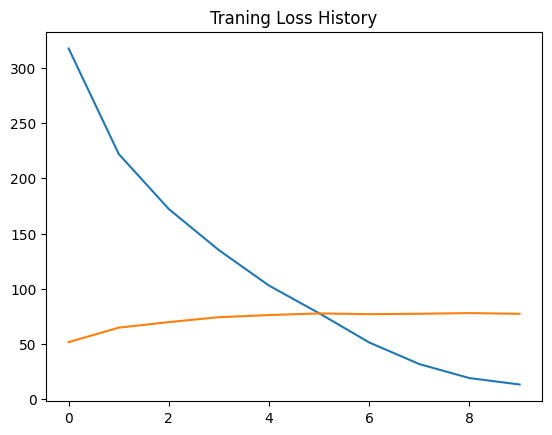

In [68]:
plt.plot(list(range(num_epochs)), loss_history)
plt.plot(list(range(num_epochs)), test_acc_history)
plt.title("Traning Loss History")
plt.show()